# Bright Sessions Text Analysis

###### Personal Notes
TextBlob seems to just have a ton of words and there associated polarity, subjectivity and intensity (for modifying next word) values that it will just average (found here: https://planspace.org/20150607-textblob_sentiment/). Makes it really good for simple stuff but this isn't the ideal thing to use. Can look into other approaches that aren't so rigid

In [5]:
# General Imports
import pandas as pd
import numpy as np
import json

# NLP Imports
from textblob import TextBlob
import re # regular expressions

#Graphing imports
import matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pywaffle import Waffle
import squarify

### Loading the Data

In [7]:
scripts_dict = {}
with open('data/bright_scripts.json', 'r') as read:
    scripts_dict = json.load(read)

## Cleaning and Organizing The Data

Cleans lines that have no speaker. These are either some form of effect (handled later) or a longer line that was formatted differently on the website. This focuses on the latter and combines them with the previous line so data isn't lost

Also deals with the one case where an effect is embedded within a spoken line

In [8]:
# Time Permitting: Probably good programming practice to put this in a preprocess method
for episode in scripts_dict:
    i = 0
    while i < len(scripts_dict[episode]):
        # Greater than 15 ignores the effects lines (handled later)
        if (':' not in scripts_dict[episode][i] and len(scripts_dict[episode][i]) > 25) or 'never been that wrong about someone before. So you can imagine how I felt' in scripts_dict[episode][i] or 'hard sticking to my own vision of something when I' in scripts_dict[episode][i]:
            # Adds the line to the previous line of dialogue
            scripts_dict[episode][i - 1] = scripts_dict[episode][i - 1] + ' ' + scripts_dict[episode][i]
            # Deletes the line that was added to the previous line to prevent repeates (must decrement i as well)
            scripts_dict[episode] = scripts_dict[episode][:i] + scripts_dict[episode][i+1:]
            i-=1
        # Only one case of this in the first episode (second and so that it only considers the case where this is embedded in spoken text)
        elif len(scripts_dict[episode][i]) > len('[sfx: writing on paper]') + 2 and '[sfx: writing on paper]' in scripts_dict[episode][i]:
            left_brack_index = scripts_dict[episode][i].index('[')
            right_brack_index = scripts_dict[episode][i].index(']')
            # Inserts the spoken line into the dict so it is considered as a sound effect later on
            scripts_dict[episode].insert(i+1, scripts_dict[episode][i][left_brack_index:right_brack_index+1])
            # Removes the sfx from the spoken line
            scripts_dict[episode][i] = scripts_dict[episode][i][:left_brack_index] + scripts_dict[episode][i][right_brack_index+2:]
            # Skips the next line (know what it is)
            i+=1
        i+=1

In [9]:
# List of effects to be considered
effect_list = ['[sfx', '[credits', '[tfx', '[passing', '[elevator', '[music', '[fade out', '(time', '[time']
Max_Character_Len = len('Director Wadsworth') #17

In [10]:
# Preps all the data to be put into a DataFrame
to_be_df = []
# Regular Expressions to remove punctuation from spoken lines
REPLACE_PUNC = re.compile("(\’)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_ELLIPSE = re.compile("(\.\.\.)")
# Gettting each episode script
for episode, script in scripts_dict.items():
    for line in script:
        # Reset effect boolean
        is_effect = False
        # Check if current line is an effect
        for effect in effect_list:
            # If the line is just an effect we break 
            if line.startswith(effect):
                is_effect = True
                to_be_df.append(('effect', episode, line))
                break
            # If it is a spoken line with an effect in it we remove it and 
        # Must be a spoken line
        if not is_effect: 
            speaker_spoken = line.split(':')
            speaker = speaker_spoken[0].strip()
            spoken = ' '.join(speaker_spoken[1:])
            # Removes all punctuation from the text. Removes ... first so that spaces are preserved in ther place
            spoken = REPLACE_ELLIPSE.sub(' ', spoken.lower())
            spoken = REPLACE_PUNC.sub('', spoken.lower())
            # Only adds the speaker if it is actually a character
            # Ignores character names that are too long or too short to actually be characters
            if len(speaker) <= Max_Character_Len and len(speaker) > 1:
                to_be_df.append((speaker, episode, spoken))

### Create the Dataframe and do Final Cleaning

In [11]:
labels = ['Speaker', 'Episode', 'Line']
df = pd.DataFrame(to_be_df, columns=labels)

In [12]:
characters = df['Speaker'].unique()
print(characters)

['effect' 'Dr. Bright' 'Sam' 'Dr Bright' 'Lauren Shippen' 'Caleb' 'Chloe'
 'Damien' 'Sarah' 'Adam' 'Agent Green' 'Voicemail voice' 'Guard'
 'Guard #2' 'Mark' 'Director Wadsworth' 'Frank' 'Charlie' 'Wadsworth'
 'Rose' 'Answering machine' '[sfx']


Fixes Repeated Character Names

In [13]:
df['Speaker'] = df['Speaker'].apply(lambda x: 'Dr. Bright' if x == 'Dr Bright' else x)
df['Speaker'] = df['Speaker'].apply(lambda x: 'Wadsworth' if x == 'Director Wadsworth' else x)
print(df['Speaker'].unique())

['effect' 'Dr. Bright' 'Sam' 'Lauren Shippen' 'Caleb' 'Chloe' 'Damien'
 'Sarah' 'Adam' 'Agent Green' 'Voicemail voice' 'Guard' 'Guard #2' 'Mark'
 'Wadsworth' 'Frank' 'Charlie' 'Rose' 'Answering machine' '[sfx']


Makes the one sfx cell an effect

In [14]:
inc_effect = df[df['Speaker'] == '[sfx']
to_add = pd.DataFrame([('effect', 44, '[sfx: click of recorder]')], columns=labels)
df = pd.concat([df, to_add])
df = df.drop([inc_effect.index[0]])

In [15]:
print(df['Speaker'].unique())

['effect' 'Dr. Bright' 'Sam' 'Lauren Shippen' 'Caleb' 'Chloe' 'Damien'
 'Sarah' 'Adam' 'Agent Green' 'Voicemail voice' 'Guard' 'Guard #2' 'Mark'
 'Wadsworth' 'Frank' 'Charlie' 'Rose' 'Answering machine']


#### Adding Columns

In [16]:
# Awful Programming practice but couldn't get it to work otherwise
df["Polarity"] = df["Line"].apply(lambda line: TextBlob(line).sentiment.polarity)
df["Subjectivity"] = df["Line"].apply(lambda line: TextBlob(line).sentiment.subjectivity)

### Setting up Graphs

In [17]:
# Find positive and negative line counts
positive_df = df[df["Polarity"] > 0]
positive_count = positive_df.shape[0]

negative_df = df[df["Polarity"] < 0]
negative_count = negative_df.shape[0]

positive_percent = int((positive_count / (positive_count + negative_count)) * 100)
negative_percent = int((negative_count / (positive_count + negative_count)) * 100)

print(str(positive_percent) + ' ' + str(negative_percent))

65 34


In [18]:
# Set up DataFrame for comparing Polaritys and Subjectivities
characters_to_linecount = dict(df['Speaker'].value_counts())
frequent_characters = [key for key, val in characters_to_linecount.items() if val > 1000]

df_frequent_characters = pd.DataFrame(columns=list(df))
for character in frequent_characters:
    df_frequent_characters = pd.concat([df_frequent_characters, df[df['Speaker'] == character]])
    # Remove Polarities of zero as they are **most likely** just lines that TextBlob didn't know what to do with
    # With these in the data is boring as it's basically just all zeros
    df_frequent_characters= df_frequent_characters[df_frequent_characters['Polarity'] != 0]

In [19]:
# Find line counts for each character and put it into a dataframe
speakers = df['Speaker'].unique()
to_be_df = []
# Go through all unique speaker names
for speaker in speakers:
    # Add the tuples to a list to easily create the new DataFrame
    line_count = df[df['Speaker'] == speaker].shape[0]
    if line_count > 200:
        to_be_df.append((speaker, line_count))
# Create the DataFrame
df_line_count = pd.DataFrame(data=to_be_df, columns=['Speaker', 'Count'])

## Graphing

c:\python36-32\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


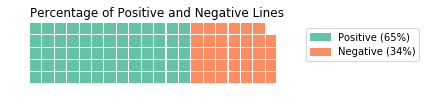

In [20]:
data = {'Positive': positive_percent, 'Negative': negative_percent}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=data, 
    title={'label': 'Percentage of Positive and Negative Lines', 'loc': 'left'},
    labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

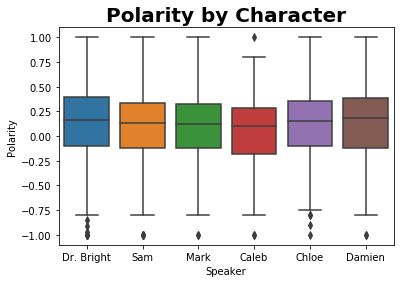

In [21]:
title_dict = {'fontsize':20, 'fontweight':'bold'}
plt = sns.boxplot(data=df_frequent_characters, x='Speaker', y='Polarity')
title = plt.set_title(label='Polarity by Character', fontdict=title_dict)

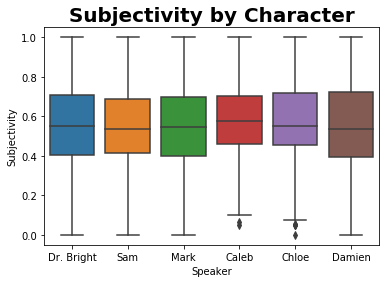

In [22]:
title_dict = {'fontsize':20, 'fontweight':'bold'}
plt = sns.boxplot(data=df_frequent_characters, x='Speaker', y='Subjectivity')
title = plt.set_title(label='Subjectivity by Character', fontdict=title_dict)

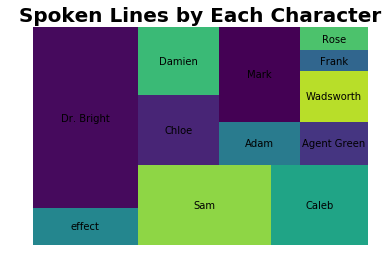

In [23]:
# ** All this is from https://mubaris.com/posts/dataviz-treemaps/ ** #
# Plotting the TreeMap
title_dict = {'fontsize':20, 'fontweight':'bold'}
plt = squarify.plot(sizes=df_line_count["Count"], label=df_line_count["Speaker"])
title = plt.set_title(label="Spoken Lines by Each Character", fontdict=title_dict)
x = plt.axis('off')

In [24]:
polarity_sorted = df.sort_values(by='Polarity')
polarity_sorted.iloc[0]
polarity_sorted.tail(30)

# Get some examples
print("Examples of Lines Classified with Postive Polarity: ")
for i in range(1,11):
    print(str(i) + ' episode-' + polarity_sorted.iloc[-1*i]['Episode'] + ': ' + polarity_sorted.iloc[-1*i]['Line'])
    
print("\n\nExamples of Lines Classified with Negative Polarity: ")
for i in range(1, 11): 
    print(str(i) + ' episode-' + polarity_sorted.iloc[i]['Episode'] + ': ' + polarity_sorted.iloc[i]['Line'])

Examples of Lines Classified with Postive Polarity: 
1 episode-48:  learned from the best 
2 episode-12:  im very happy to see you sam ive been worried about you 
3 episode-42:  its the greatest feeling in the world 
4 episode-45:  the best dont forget that while im gone 
5 episode-56:  chloe what are you doing here its wonderful to see you how are you
6 episode-30:  wonderful now lets get started on this questionnaire shall we
7 episode-28:  its perfectly alright hows school going
8 episode-17:  wonderful be a doll get me a croissant will you
9 episode-56:  i will i must say im very impressed 
10 episode-52:  i just wonder if this is the best thing for her shes distracted i dont want her to make any rash decisions 


Examples of Lines Classified with Negative Polarity: 
1 episode-46:  god you look terrible
2 episode-1:  its horrible
3 episode-53:  no no its alright youre always preparing for the worst i get it 
4 episode-35:  yeah this is sort of your worst nightmare isnt it
5 episode